# Python Implementation of Experiments for Thesis

### Import Libraries

In [1]:
#-------------------------Setting the randomness-------#
import numpy as np
np.random.seed(1)

from tensorflow import set_random_seed
set_random_seed(1)
#------------------------------------------------------#

import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten, Activation,Reshape

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

## Load in training and testing dataset

In [2]:
from numpy import load
train_data = load('training_data.npy')
test_data = load('testing_data.npy')

## Augmenting Training Data 

In [3]:
print(len(train_data[0]))

62501


In [4]:
print(train_data[3874])
print(train_data[3875])
print(len(train_data[3875:]))

[1.         0.05098039 0.05490196 ... 0.05098039 0.04705882 0.04705882]
[0.         0.09019608 0.07058824 ... 0.44705883 0.45882353 0.44313726]
1341


In [5]:
print(test_data[389])
print(test_data[390])

[1.         0.03137255 0.04705882 ... 0.         0.         0.        ]
[0.         0.12156863 0.12156863 ... 0.1254902  0.12941177 0.13333334]


 ## Function to choose balancing of training data

In [6]:
def balanced(option):
    if(option=="yes"):
        training_data = np.concatenate((train_data[0:1341],train_data[3875:]),axis=0)
        testing_data = np.concatenate((test_data[0:234],test_data[390:]))
        return training_data,testing_data
    else:
        training_data = train_data
        testing_data = test_data
        return training_data,testing_data


In [7]:
training_data,test_data=balanced("no")
print(training_data.shape)
print(test_data.shape)

X_train,X_val,Y_train,Y_val = train_test_split(training_data[0:,1:],training_data[0:,0:1],test_size=0.1,random_state = 1,shuffle=True,stratify=training_data[0:,0:1])

(5216, 62501)
(624, 62501)


In [8]:
print('All (class distribution):', np.bincount(list(map(float, training_data[0:,0:1]))) / float(len(training_data)) * 100.0)
print('Training (class distribution):', np.bincount(list(map(float,Y_train))) / float(len(Y_train)) * 100.0)
print('Validation (class distribution):', np.bincount(list(map(float,Y_val))) / float(len(Y_val)) * 100.0)

All (class distribution): [25.70935583 74.29064417]
Training (class distribution): [25.71367703 74.28632297]
Validation (class distribution): [25.67049808 74.32950192]


In [9]:
print(len(X_val))

522


In [10]:
X_test = test_data[0:,1:]
Y_test = test_data[0:,0:1]


In [11]:
y_train_ohe = keras.utils.to_categorical(Y_train, 2)
y_test_ohe = keras.utils.to_categorical(Y_test, 2)
y_val_ohe = keras.utils.to_categorical(Y_val,2)

In [12]:
X_train = X_train.reshape(X_train.shape[0],250,250,1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0],250,250,1)
print(X_test.shape)
X_val = X_val.reshape(X_val.shape[0],250,250,1)
print(X_val.shape)

(4694, 250, 250, 1)
(624, 250, 250, 1)
(522, 250, 250, 1)


## Create 2D CNN 

## 1. Define Sequential Model
## 2. Add 2D CNN with 32 filters,3x3 filters
## 3. Apply Relu
## 4. Apply Batch Norm
## Repeat x2
## 5. Apply MaxPooling(2,2)
## 6. Send through Fully Connected Layer


In [13]:
def create_model():
    model_CNN = Sequential()
    model_CNN.add(Conv2D(32,(3,3),input_shape=(250,250,1)))
    model_CNN.add(Activation('relu'))
    model_CNN.add(BatchNormalization(axis=-1))
    model_CNN.add(Conv2D(32, (3, 3)))
    model_CNN.add(Activation('relu'))
    model_CNN.add(BatchNormalization(axis=-1))

    model_CNN.add(MaxPooling2D(pool_size=(2,2)))
    
    model_CNN.add(Flatten())

    # Fully connected layer
    model_CNN.add(Dense(128))
    model_CNN.add(Activation('relu'))
    model_CNN.add(BatchNormalization())
    model_CNN.add(Dropout(0.2))
    model_CNN.add(Dense(2))
    model_CNN.add(Activation('softmax'))
    
    return model_CNN

# Setup for the experiment below

## 1. Model is ran with the above architeture 
## 2.Trained on Imbalanced Set
## 3. Tested on Balanced Set

# This is a test to see if running 10 experiments for the same setup of model produces the same results 

In [14]:
history_array = []
accuracy = []
model_array = []
for i in range(0,5):
    model = create_model()  
    opt = optimizers.SGD(lr=0.01)
    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    history = model.fit(X_train, y_train_ohe,shuffle=True,batch_size=32,epochs=10,validation_data=(X_val, y_val_ohe))# model
    model_array.append(model)
    history_array.append(history)
    score = model.evaluate(X_test, y_test_ohe)
    accuracy.append(round(score[1]*100))

W0227 12:01:24.717839 139627288450880 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0227 12:01:27.479528 139627288450880 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0227 12:01:28.095582 139627288450880 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:214: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 4694 samples, validate on 522 samples
Epoch 1/10
4694/4694 [==============================] - 13s 3ms/step - loss: 0.2174 - accuracy: 0.9269 - val_loss: 1.4166 - val_accuracy: 0.7433
Epoch 2/10
4694/4694 [==============================] - 10s 2ms/step - loss: 0.0889 - accuracy: 0.9759 - val_loss: 1.9195 - val_accuracy: 0.7433
Epoch 3/10
4694/4694 [==============================] - 10s 2ms/step - loss: 0.0529 - accuracy: 0.9853 - val_loss: 0.5203 - val_accuracy: 0.7644
Epoch 4/10
4694/4694 [==============================] - 10s 2ms/step - loss: 0.0437 - accuracy: 0.9881 - val_loss: 0.5528 - val_accuracy: 0.7816
Epoch 5/10
4694/4694 [==============================] - 11s 2ms/step - loss: 0.0347 - accuracy: 0.9911 - val_loss: 0.0821 - val_accuracy: 0.9751
Epoch 6/10
4694/4694 [==============================] - 11s 2ms/step - loss: 0.0207 - accuracy: 0.9953 - val_loss: 0.0760 - val_accuracy: 0.9751
Epoch 7/10
4694/4694 [==============================] - 11s 2ms/step - loss: 0.0134

In [24]:
print(accuracy)

[87, 79, 87, 79, 73]


# Plot the Model accuracy on the Training and Validation

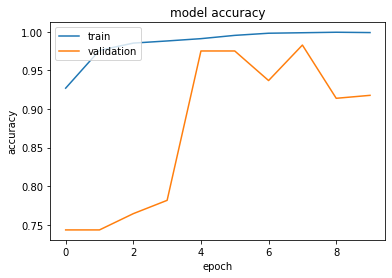

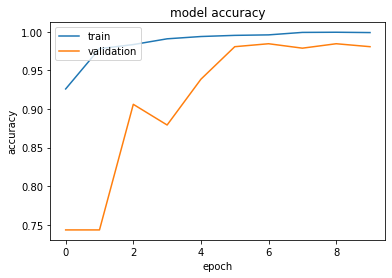

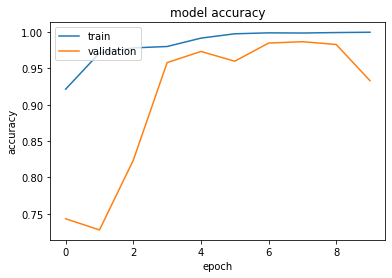

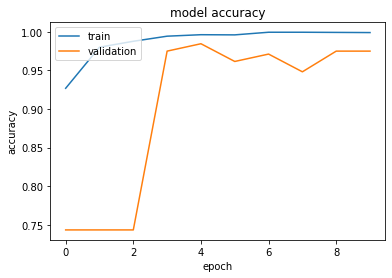

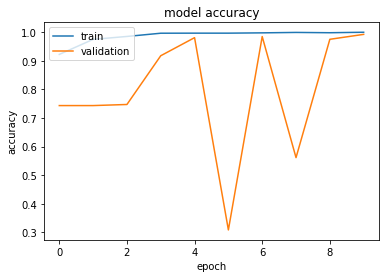

In [27]:
import matplotlib.pyplot as plt
count = 0; 
for i in history_array:

    plt.plot(i.history['accuracy'])
    plt.plot(i.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validation'],loc='upper left')
    name = 'train_vs_validation_accuracy_shuffled_btch_32_epoch10_SGD_dropout_0.2_' + str(count) + '.png'
    plt.savefig(name)
    count = count+1
    plt.show()




In [ ]:
## What does the above graph tell us about the model 
## -> What we see is that when it comes to training the model, it has high accuracy on the training set.
# However when looking at the testing accuracy we can see the accuracy after every epoch is quite volatile. 
# What this tell us is that the model has clearly not been able to learn from training data. When looking at the graph it also shows overfitting 
## But this comes secondary to the concept of the model actually underfitting even though the the accuracy on the training data is high. 

# Plot the Model Loss on the Training and Validation

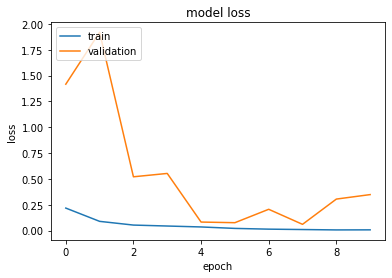

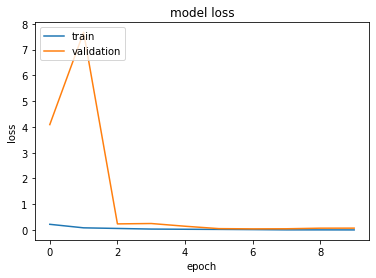

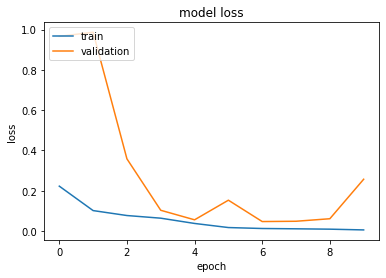

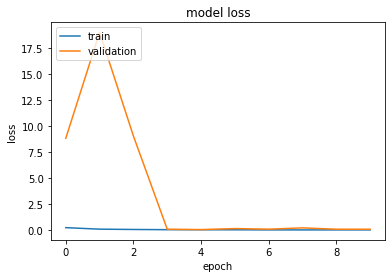

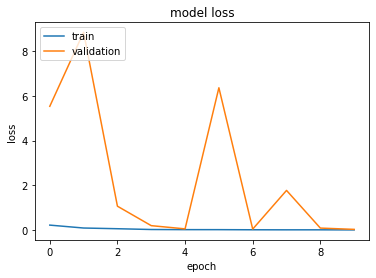

In [28]:
# summarize history for loss
count = 0 
for i in history_array:
    plt.plot(i.history['loss'])
    plt.plot(i.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    name = 'train_vs_test_loss_shuffled_btch32_epoch10_SGD_dropout_0.2_' + str(count) + '.png'
    plt.savefig(name)
    count = count +1
    plt.show()
    
  

In [ ]:
score = model_array[1].evaluate(X_test, y_test_ohe)
print('Loss ' , score[0])
print('Test accuracy: ', score[1]*100)

In [29]:
from sklearn.metrics import confusion_matrix
def classification_report():
    
    for i in model_array:
        y_pred = i.predict_classes(X_test)
        matrix = ["TN","FP"],["FN","TP"]
        print(matrix[0])
        print(matrix[1])

        ##Lets Visualise the output
        conf=confusion_matrix(Y_test, y_pred)
        print("Confusion Matrix")
        print(conf)
        # or we can use a heatmap from the seaborn library
        #import seaborn as sn
        #df_cm = pandas.DataFrame(conf, range(2), range(2))
        #sn.set(font_scale=1.4)#for label size
        #sn.heatmap(df_cm, cmap="YlGnBu", annot=True, annot_kws={"size": 20},fmt="d")# font size

        from sklearn.metrics import classification_report
        print(classification_report(Y_test,y_pred));
        



## Lets Visualise the output of Confusion Matrix & Classification Report

In [30]:
classification_report()

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[173  61]
 [ 22 368]]
              precision    recall  f1-score   support

         0.0       0.89      0.74      0.81       234
         1.0       0.86      0.94      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.84      0.85       624
weighted avg       0.87      0.87      0.86       624

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[106 128]
 [  6 384]]
              precision    recall  f1-score   support

         0.0       0.95      0.45      0.61       234
         1.0       0.75      0.98      0.85       390

    accuracy                           0.79       624
   macro avg       0.85      0.72      0.73       624
weighted avg       0.82      0.79      0.76       624

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[173  61]
 [ 20 370]]
              precision    recall  f1-score   support

         0.0       0.90      0.74      0.81       234
         1.0       0.86      0.95      